# Air Quality Analysis in Beijing


In [25]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

In [15]:
def calculate_aqi(row):
    pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
    max_value = row[pollutants].max()
    
    if max_value <= 50:
        return 'Excelent'
    elif max_value <= 100:
        return 'Good'
    elif max_value <= 150:
        return 'Slightly Polluted'
    elif max_value <= 200:
        return 'Lightly Polluted'
    elif max_value <= 250:
        return 'Moderately Polluted'
    elif max_value <= 300:
        return 'Heavily Polluted'
    else:
        return 'Severely Polluted'


In [16]:
data_file = "Beijing_Multisite_air_Quality_data.csv"
data_df = pd.read_csv(data_file)
data_df['AQI'] = data_df.apply(calculate_aqi, axis=1)
data_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,Heavily Polluted
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,Heavily Polluted
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,Heavily Polluted
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,Heavily Polluted
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,Heavily Polluted


In [17]:
print(f"DataFrame Shape: {data_df.shape}\n")
data_df.info()

DataFrame Shape: (420768, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
 17  AQI      420768 non-null  object 
dtypes: float64(11), int64(4), object(3)
memory usage: 57.8+ MB


In [18]:
data_df.groupby('station').size().reset_index(name='row_count')

,station,row_count
0,Aotizhongxin,35064
1,Changping,35064
2,Dingling,35064
3,Dongsi,35064
4,Guanyuan,35064
5,Gucheng,35064
6,Huairou,35064
7,Nongzhanguan,35064
8,Shunyi,35064
9,Tiantan,35064


In [24]:
pprint(data_df.groupby(['station', 'AQI']).size().reset_index(name='row_count'))

          station                  AQI  row_count
0    Aotizhongxin             Excelent        203
1    Aotizhongxin                 Good        473
2    Aotizhongxin     Heavily Polluted       2590
3    Aotizhongxin     Lightly Polluted       1419
4    Aotizhongxin  Moderately Polluted        117
..            ...                  ...        ...
79  Wanshouxigong     Heavily Polluted       2335
80  Wanshouxigong     Lightly Polluted        943
81  Wanshouxigong  Moderately Polluted         77
82  Wanshouxigong    Severely Polluted      30799
83  Wanshouxigong    Slightly Polluted        267

[84 rows x 3 columns]


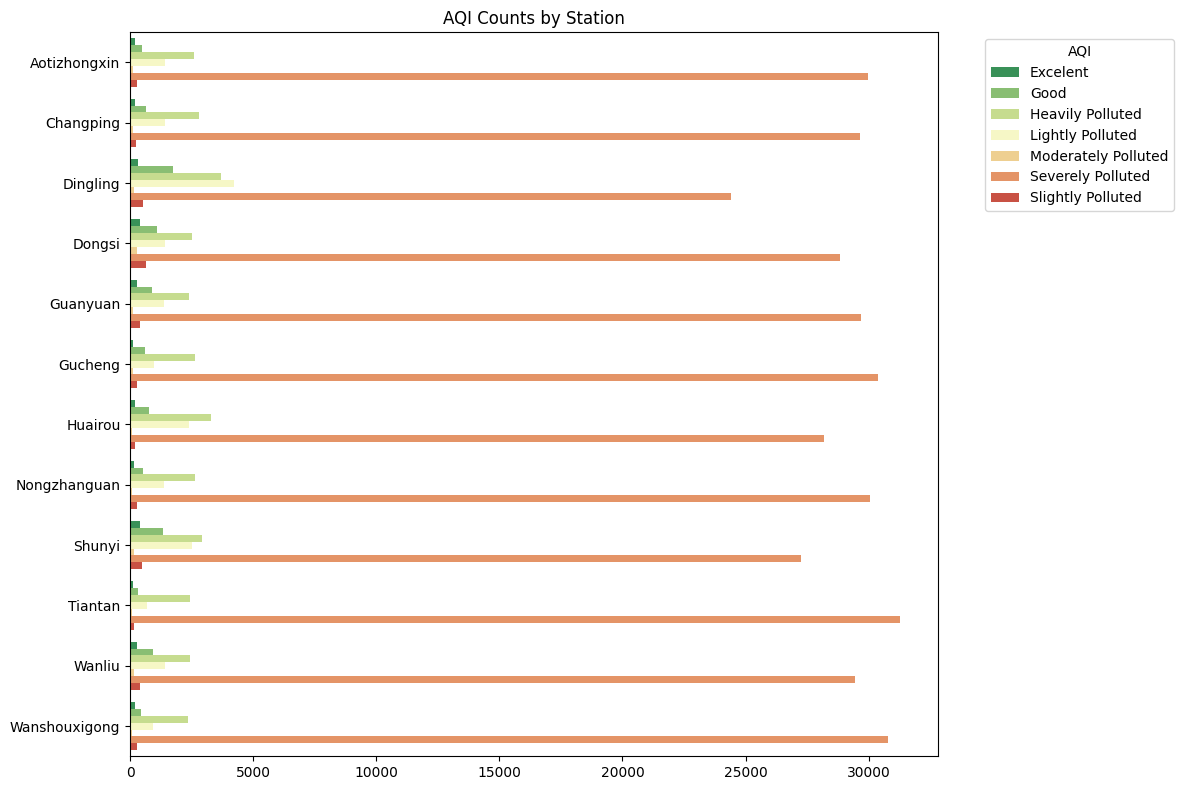

In [37]:
# Grouping by 'station' and 'AQI'
result_df = data_df.groupby(['station', 'AQI']).size().reset_index(name='row_count')

colors = sns.color_palette("RdYlGn", 7)
reversed_colors = colors[::-1]

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(y='station', x='row_count', hue='AQI', data=result_df, palette=reversed_colors)

# Adding titles and labels
plt.title('AQI Counts by Station')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='AQI', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
filtered_df = data_df[data_df['station'].isin(['Aotizhongxin', 'Changping'])]
filtered_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


## Data Cleaning

In [10]:
data_df.isnull().sum()

year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

## Summary Statistics

## Time Series Plots

## Histograms

## Correlation Analysis

## Trend Analysis

## Reporting